In [1]:
import numpy as np
import matplotlib.pyplot as plt
import test_neighborly_integration

from neighborly import Neighborly
from neighborly.core.life_event import AllEvents
from neighborly.core.ecs import GameObject

Try and grab relevant info from the sim

In [2]:
FILE_LOCATION = "G:/My Drive/UCSC/Negotiation/test_neighborly/images"

SIMULATION_CONFIGS = [
    {
        "duration": 15,
        "seed": 23,
        "enable_negotiation": True
    },
    {
        "duration": 15,
        "seed": 23,
        "enable_negotiation": False
    },
]
SIM_NUM = len(SIMULATION_CONFIGS)


sims = []

for config in SIMULATION_CONFIGS:
    AllEvents.clear_event_listeners()
    GameObject.clear_event_listeners()
    sims.append(test_neighborly_integration.run_sim_with_negotiation(**config))
    

Running some initial Speakeasy simulation...
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Dyersburg), (Character: Rosanna Jeans(3))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Dyersburg), (Character: Greer Jeans(4))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Dyersburg), (Character: Conway Jeans(8))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Dyersburg), (Character: Aggi Jeans(14))
MoveResidenceEvent [@ 0001-01-01T00:00:00] (Residence: residence::default::house(2)), (Character: Rosanna Jeans(3)), (Character: Greer Jeans(4)), (Character: Conway Jeans(8)), (Character: Aggi Jeans(14))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Dyersburg), (Character: Dionis Vane(23))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Dyersburg), (Character: Natasha Vane(24))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Dyersburg), (Character: Salem Vane(28))
MoveResidenceEvent [@ 0001-01-01T00:00:00] (Residence: residence::

In [3]:
from neighborly.exporter import export_to_json

for idx, sim in enumerate(sims):
  with open(f"{FILE_LOCATION}/neighborly_{sim.config.seed}-{idx}.json", "w") as f:
    f.write(export_to_json(sim))

In [4]:
from neighborly.components import GameCharacter, Business
from neighborly.core.ecs import Active
from neighborly.components import Name
from speakeasy.events import get_associated_business
from speakeasy.components import Inventory

def calculate_item_distributions(sim : Neighborly):
    item_dists = {}
    item_owners = sim.world.get_components((Active, GameCharacter, Inventory))
    num_item_owners = len(item_owners)
    names_of_item_owners = []
    business_types = set({'None'})

    #create all the keys in the item_dists (basically what items are in the sim?) and setup axis labels per character
    #also track the kinds of businesses present
    for character_index in range(num_item_owners):
        (id, (active, gamechar, inventory)) = item_owners[character_index]
        
        name_to_append = gamechar.full_name

        if biz := get_associated_business(gamechar.gameobject):
            bizname = biz.gameobject.get_component(Name).value
            relationship_to_business_label = "?"
            if biz.owner == id:
                relationship_to_business_label = "O"
            elif id in biz.get_employees():
                relationship_to_business_label = "E"

            name_to_append += f" [{relationship_to_business_label}@{bizname}]"
            business_types.add(bizname)
        else:
            name_to_append += " [None]"

        names_of_item_owners.append(name_to_append)
        
        for key in inventory.items:
            if key not in item_dists:
                item_dists[key] = []

    #count the # of each item from above in the inventory of each character.
    for key in item_dists:
        for character_index in range(num_item_owners):
            (id, (active, gamechar, inventory)) = item_owners[character_index]            
            count = 0
            if key in inventory.items:
                count = inventory.items[key]
            item_dists[key].append(count)

    return (names_of_item_owners, item_dists, business_types)

In [5]:
from neighborly.core.relationship import RelationshipManager, get_relationship
from neighborly.core.relationship import Friendship
from speakeasy.components import Respect, Favors

def calculate_relationship_distributions(sim : Neighborly):
    relationship_distributions = {
        Respect.__name__ : [],
        Friendship.__name__ : [],
        Favors.__name__ : []
    }

    relationship_havers = sim.world.get_components((Active, GameCharacter, RelationshipManager))
    for (id, (_, char, rmanager)) in relationship_havers:
        for (id2, (_, char2, rmanager)) in  relationship_havers:
            if id == id2:
                continue
            rel = get_relationship(sim.world.get_gameobject(id), sim.world.get_gameobject(id2))
            respect = rel.get_component(Respect).get_value()
            friendship = rel.get_component(Friendship).get_value()
            favors = rel.get_component(Favors).favors
            
            relationship_distributions[Respect.__name__].append(respect)
            relationship_distributions[Friendship.__name__].append(friendship)
            relationship_distributions[Favors.__name__].append(favors)

    return relationship_distributions

def plot_relationship_distributions(relationship_distributions):
    fig = plt.figure(figsize=(18,4))
    for idx, key in enumerate(relationship_distributions[0]):
        plt.subplot(1, 3, idx+1)
        counts, bins, patches = plt.hist([relationship_distributions[sim_idx][key] for sim_idx in range(SIM_NUM)])
        plt.xticks(bins)
        plt.yscale('log')
        plt.legend(["With Negotiation", "Without Negotiation"])
        plt.title(f"Distribution of {key}")
    plt.show()

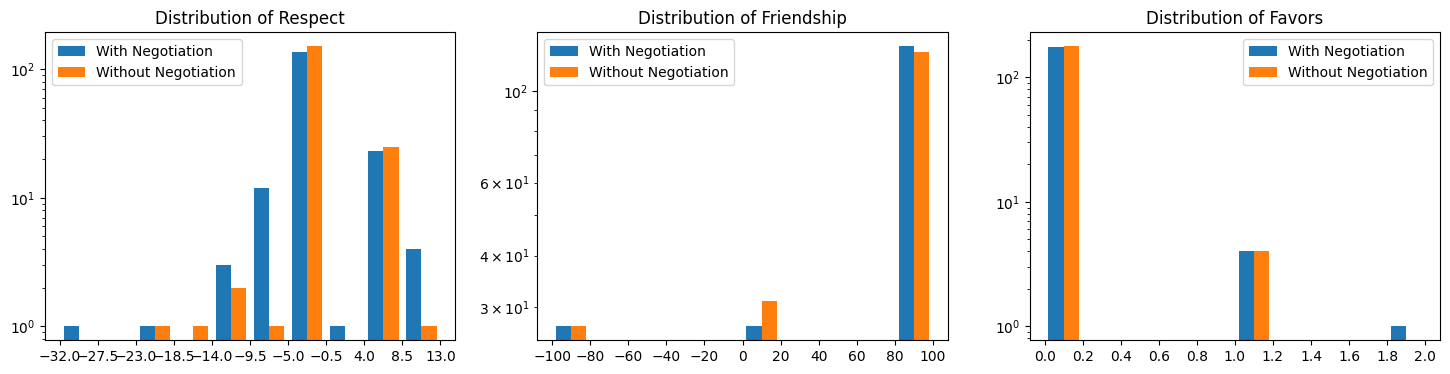

In [6]:
rel_dists = [calculate_relationship_distributions(sim) for sim in sims]
plot_relationship_distributions(rel_dists)

In [7]:
COLORS = {'booze':'C0','corn':'orange','money':'green'}

def plot_item_distributions(names, distributions, business_types):
    #distributions is a dict<item, array where array[i] is how many of item char #i has.>
    x_labels = names
    for dist in distributions.items():
        plt.barh(x_labels, dist[1], color=COLORS[dist[0]])
    plt.locator_params(axis="x", integer=True)
    plt.legend([str(k) for k in distributions.keys()])
    plt.show()

    fig = plt.figure(figsize=(7,14))
    business_types = list(business_types)
    business_types.sort()
    for i, type in enumerate(business_types):
        filtered_names = [n for n in names if type in n]
        index_list = [names.index(n) for n in filtered_names]
        filtered_distributions = dict((d[0], [d[1][i] for i in index_list]) for d in distributions.items())

        plt.subplot(4,1,i+1)
        x_labels = filtered_names
        for dist in filtered_distributions.items():
            plt.barh(x_labels, dist[1], color=COLORS[dist[0]])
        plt.locator_params(axis="x", integer=True)
        plt.legend([str(k) for k in filtered_distributions.keys()])
        plt.title(f"Only {type}")
    #plt.show()
    plt.tight_layout()
    return fig

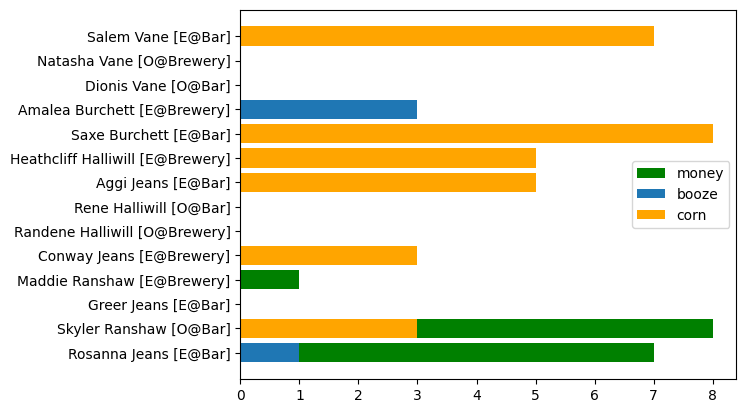

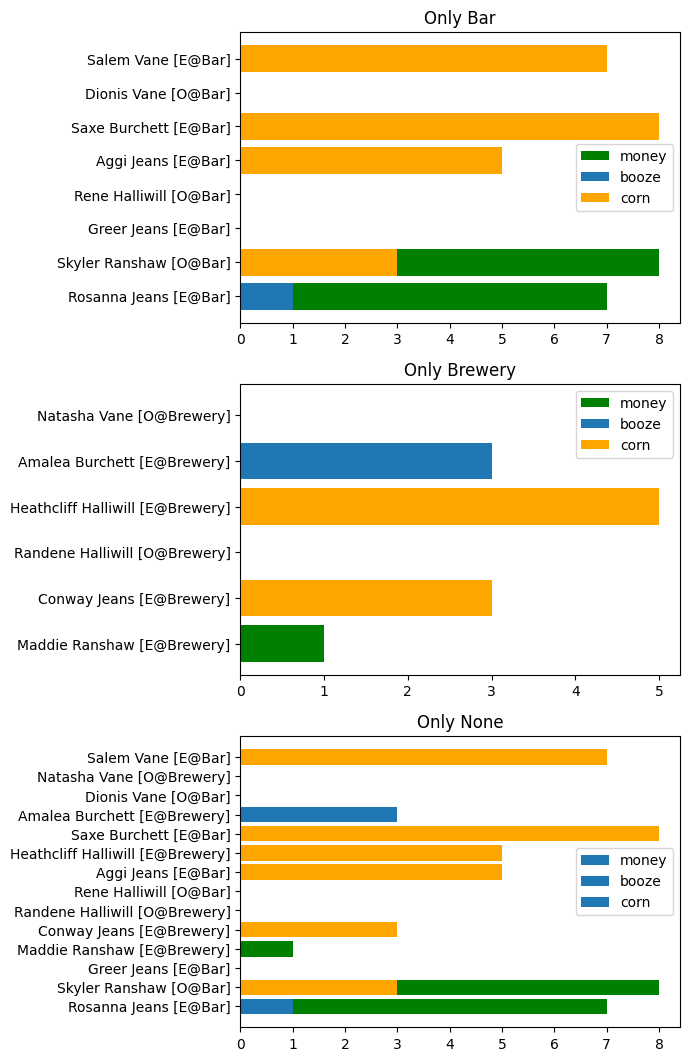

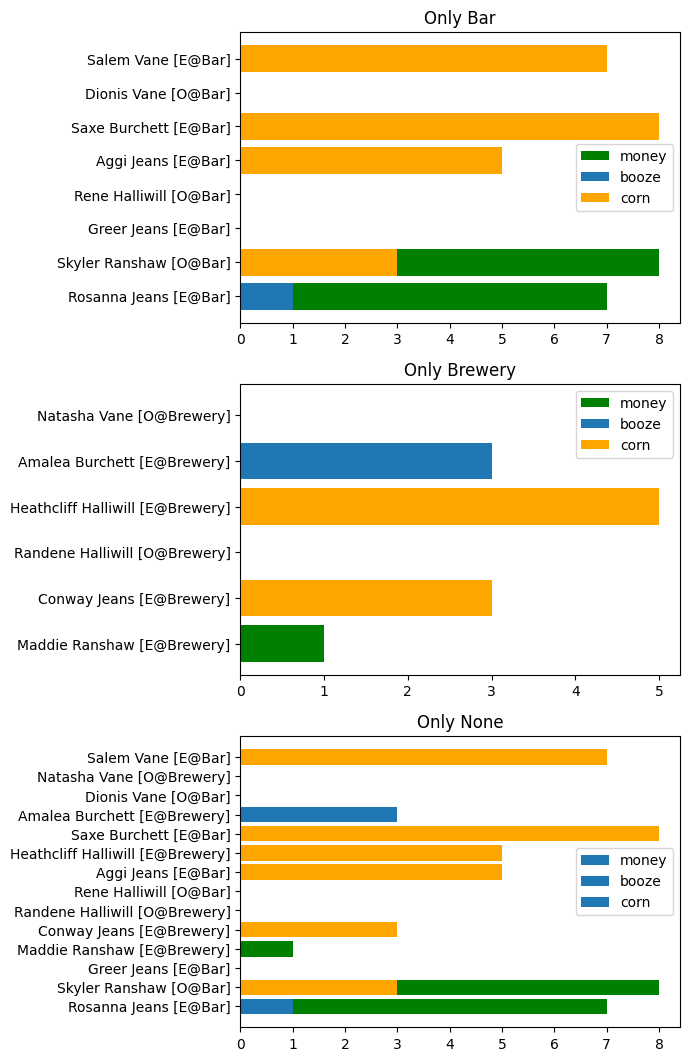

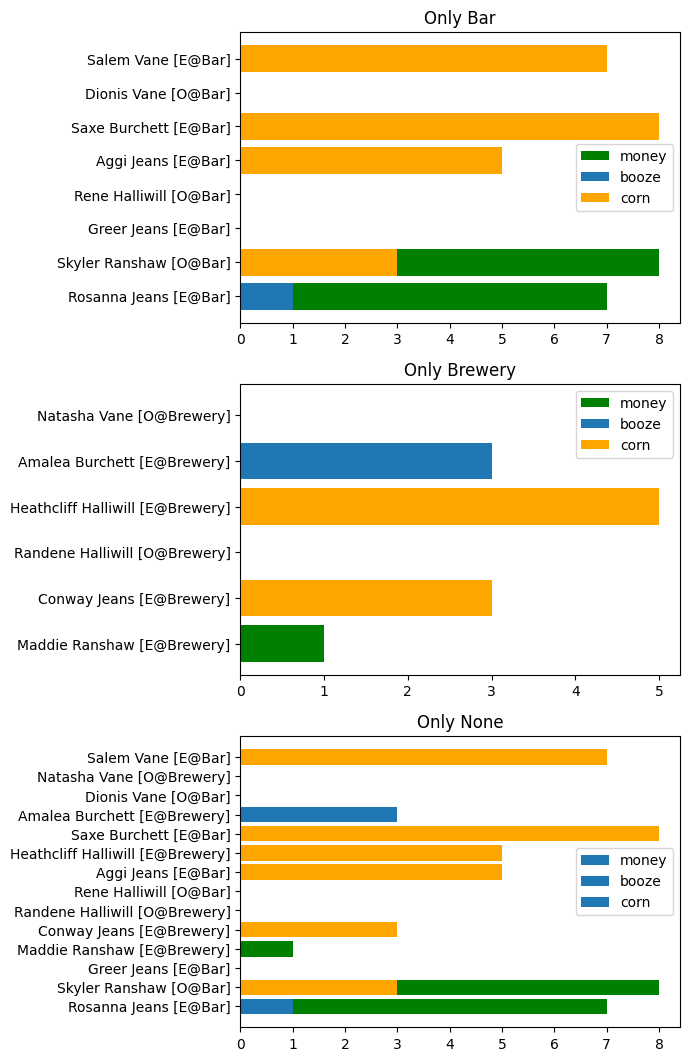

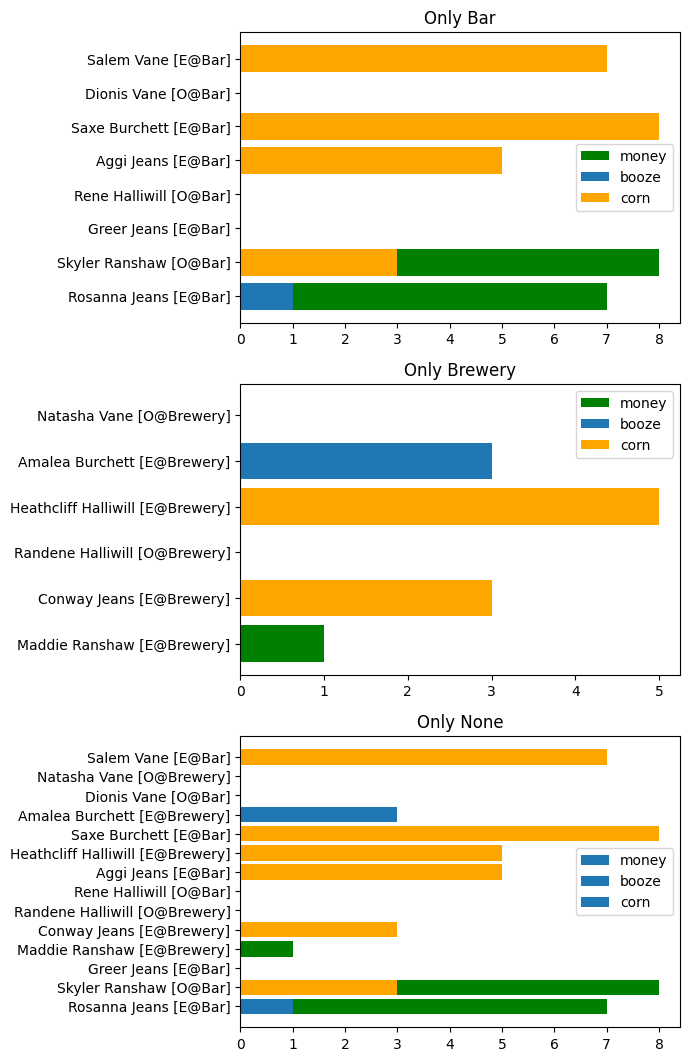

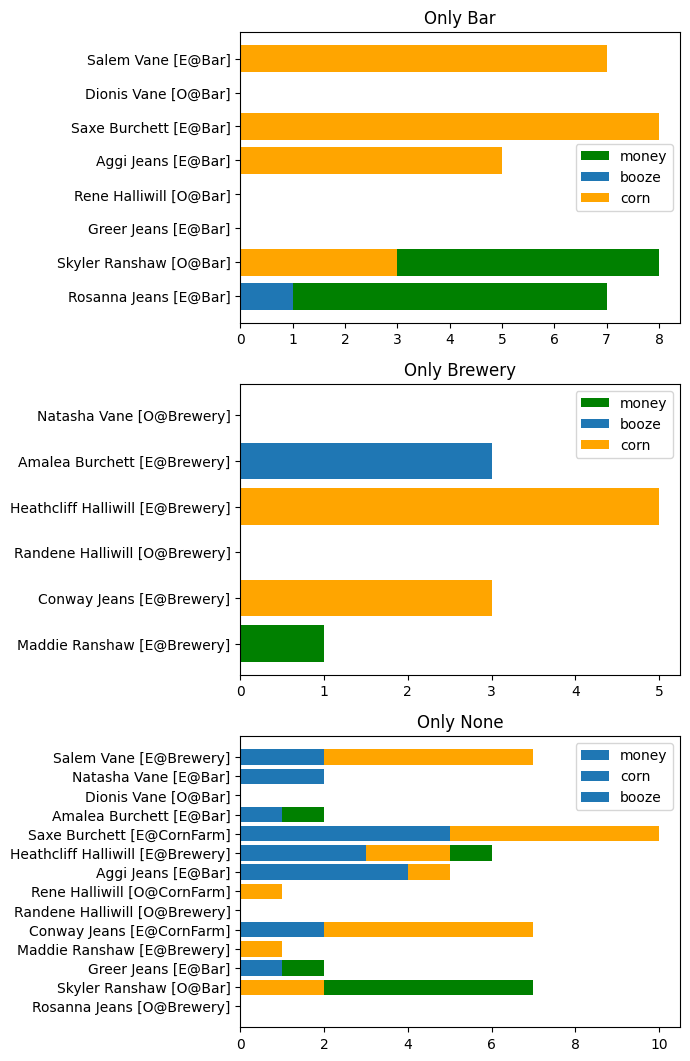

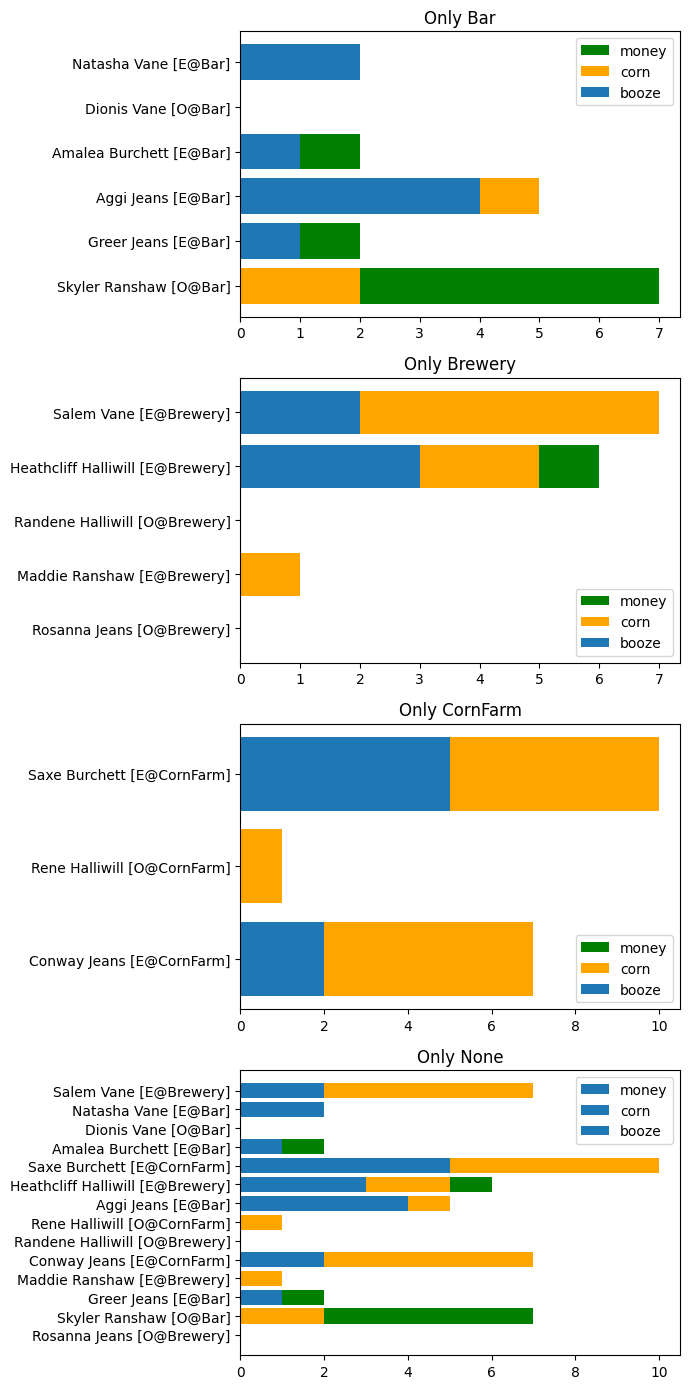

Skipped Negotiation as it's disabled.


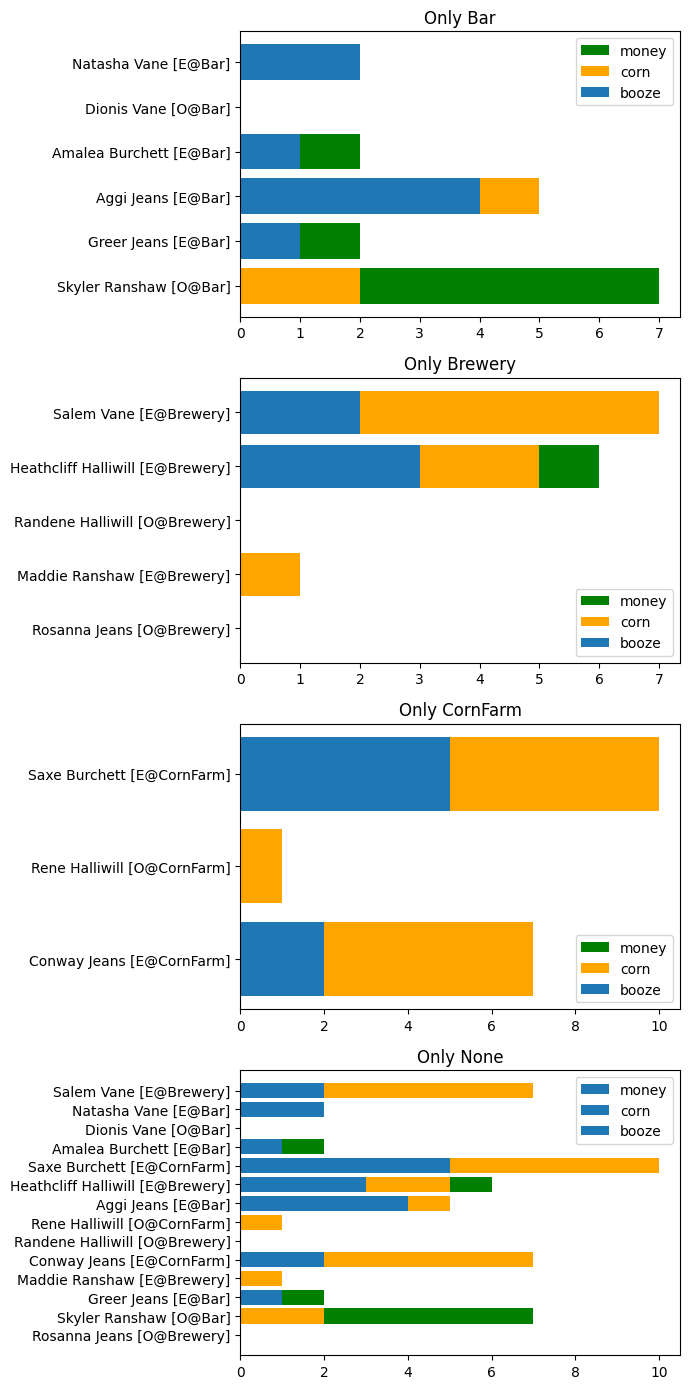

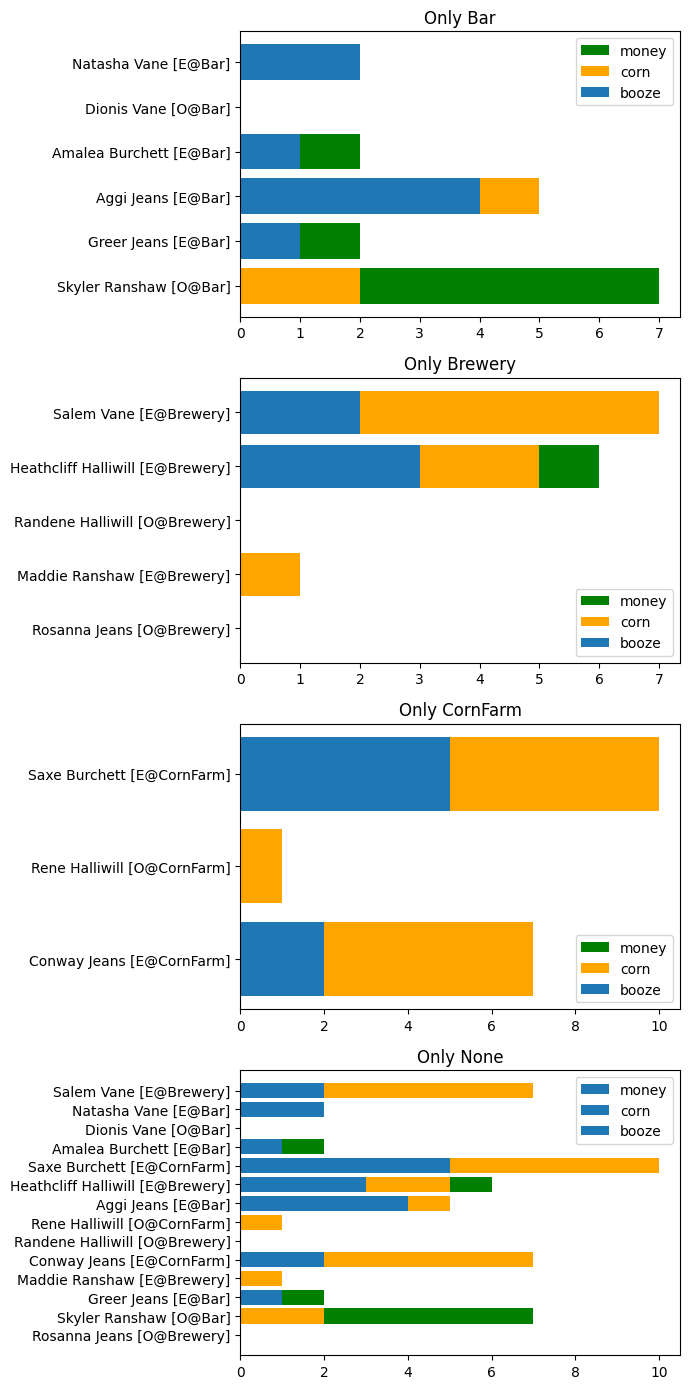

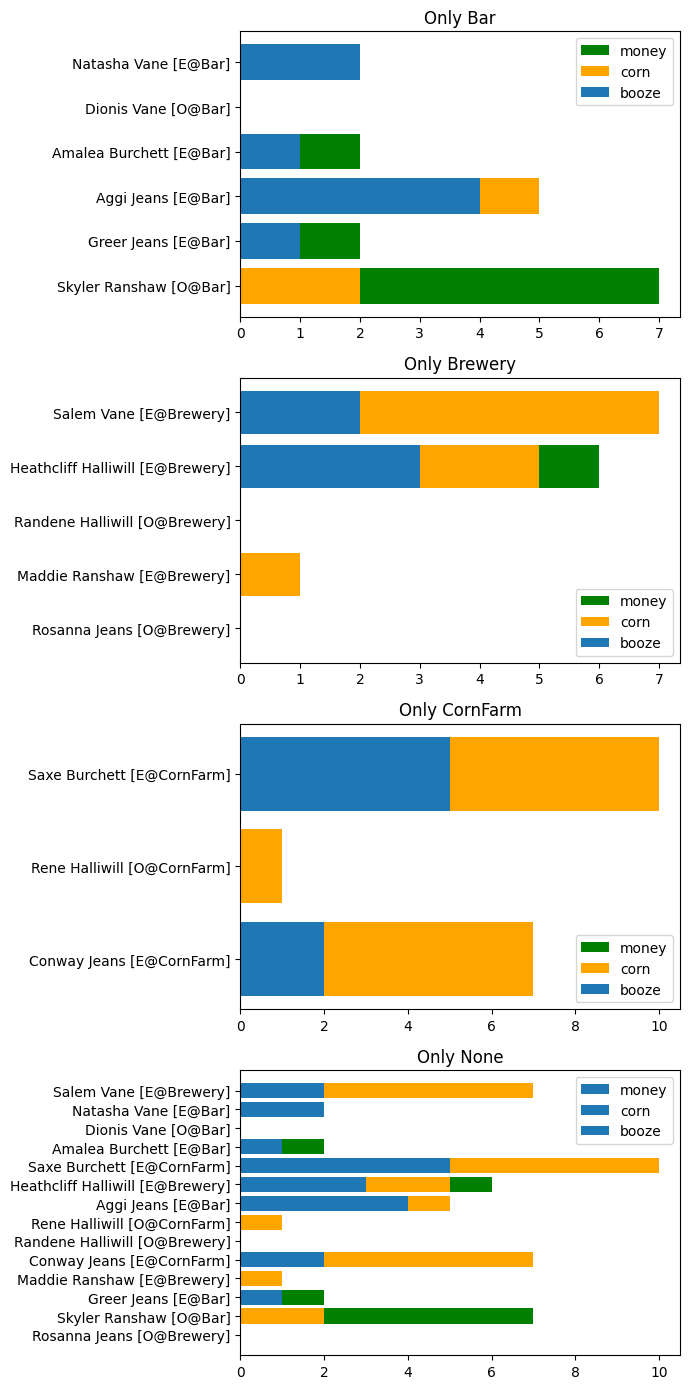

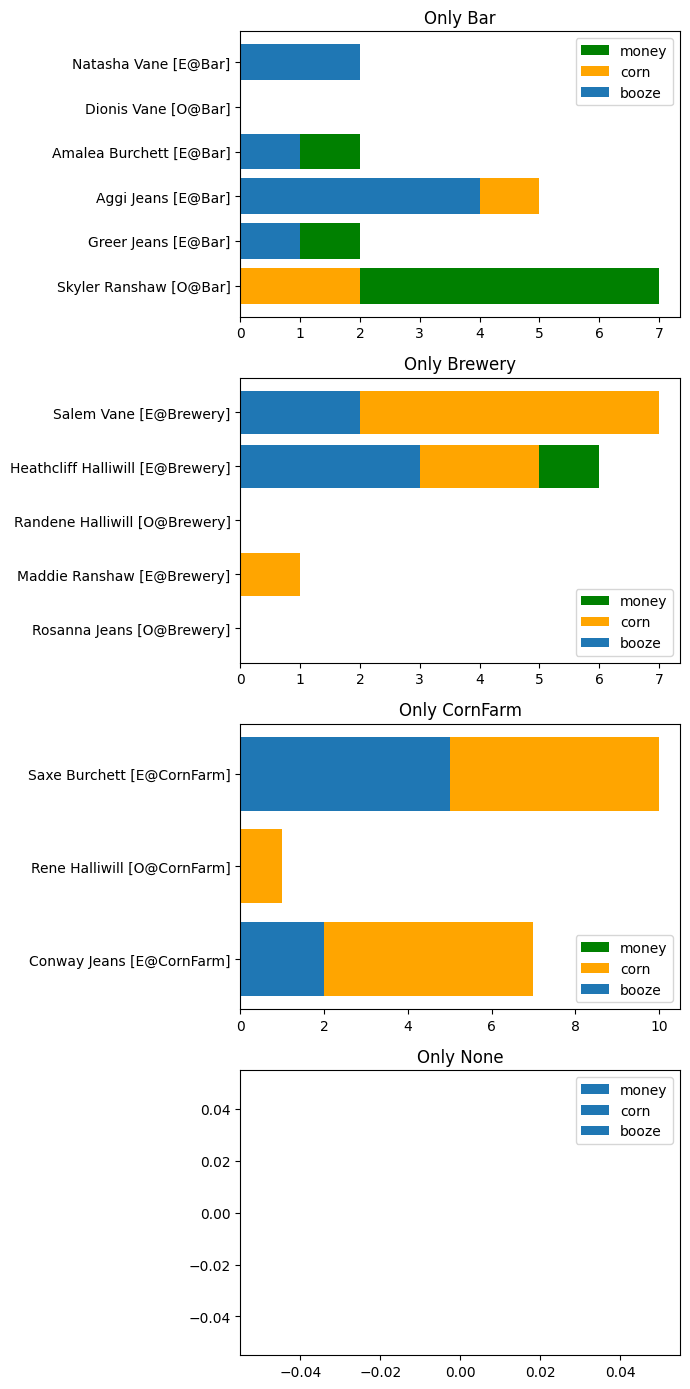

In [8]:
import os, glob

SIM_GIF_NUM_STEPS = 5

for idx in range(SIM_NUM):
    map(os.remove, glob.glob(f"{FILE_LOCATION}/sim-{idx}-*.png"))

    for step in range(SIM_GIF_NUM_STEPS):
        sim = sims[idx]
        names, distributions, business_types = calculate_item_distributions(sim)
        fig = plot_item_distributions(names, distributions, business_types)
        fig.savefig(f"{FILE_LOCATION}/sim-{idx}-{step}.png")
        if step < SIM_GIF_NUM_STEPS-1:
            sim.step()

In [9]:
from PIL import Image
import glob

for idx in range(SIM_NUM):
    # Create the frames
    frames = []
    imgs = glob.glob(f"{FILE_LOCATION}/sim-{idx}-*.png")
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)
    
    # Save into a GIF file that loops forever
    frames[0].save(FILE_LOCATION + f"/sim-{idx}.gif", format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=50, loop=0)

In [16]:
import pygraphviz as pgv
from neighborly.core.relationship import RelationshipManager
from neighborly.core.life_event import EventHistory
from neighborly.utils.common import get_relationship
from speakeasy.components import Respect

from speakeasy.events import NegotiateEvent, TradeEvent, GoodWordEvent, TellAboutEvent, TheftEvent, HelpWithRivalGangEvent

#NOTE: yeah bro don't include this color mapping when showing anyone bc its kinda crazy
from speakeasy.components import Ethnicity, EthnicityValue
ethnicity_color_dict = {
   EthnicityValue.Asian : "yellow",
   EthnicityValue.Black : "brown",
   EthnicityValue.Latino : "orange",
   EthnicityValue.NativeAmerican : "red",
   EthnicityValue.White : "white",
   EthnicityValue.NotSpecified : "grey"
}

def make_relationship_graph(sim : Neighborly, component_to_test):
   relationship_graph = pgv.AGraph(strict=False, directed=False)
   relationship_graph.graph_attr["label"] = f"Graph of {component_to_test.__name__}"
   relationship_graph.graph_attr["outputorder"] = 'edgesfirst'
   relationship_havers = sim.world.get_components((Active, GameCharacter, RelationshipManager))
   num_relationship_havers = len(relationship_havers)

   incoming_respect_array = []
   for haver in relationship_havers:
      (id, (active, gamechar, relationship_manager)) = haver
      respect_values = [sim.world.get_gameobject(i).get_component(Respect).get_value() for i in relationship_manager.incoming.values()]
      respect = sum(respect_values)
      incoming_respect_array.append(respect)

   incoming_respect_array = np.array(incoming_respect_array)
   incoming_respect_array -= min(incoming_respect_array)
   incoming_respect_array = [20 + 100*(r/max(incoming_respect_array)) for r in incoming_respect_array]

   for character_index in range(num_relationship_havers):
      (id, (active, gamechar, relationship_manager)) = relationship_havers[character_index]
      character_object = sim.world.get_gameobject(id)
      
      node_label = f"{gamechar.full_name}"

      #mark node with business info
      if biz := get_associated_business(character_object):
         relationship_to_business_label = "?"
         if biz.owner == id:
               relationship_to_business_label = "O"
         elif id in biz.get_employees():
               relationship_to_business_label = "E"
         node_label += f"\n{relationship_to_business_label}@{biz.gameobject.get_component(Name).value}#{biz.gameobject._id}"

      #mark node with event history info
      history = character_object.get_component(EventHistory)
      event_type_counts = {}
      for event in history:
         if type(event) in [NegotiateEvent, TradeEvent, GoodWordEvent, TellAboutEvent, TheftEvent, HelpWithRivalGangEvent]:
            if type(event).__name__[0:2] not in event_type_counts:
               event_type_counts[type(event).__name__[0:2]] = 1
            else:
               event_type_counts[type(event).__name__[0:2]] += 1
      node_label += f"\n" + " ".join([f"{k}:{event_type_counts[k]}" for k in event_type_counts])

      #mark node with demographic info
      relationship_graph.add_node(gamechar.full_name)
      relationship_graph.get_node(gamechar.full_name).attr["label"] = f"({round(incoming_respect_array[character_index])-20}) " + node_label
      relationship_graph.get_node(gamechar.full_name).attr["style"] = "filled"
      relationship_graph.get_node(gamechar.full_name).attr["fillcolor"] = ethnicity_color_dict[character_object.get_component(Ethnicity).ethnicity]
      relationship_graph.get_node(gamechar.full_name).attr["width"] = incoming_respect_array[character_index]/20
      relationship_graph.get_node(gamechar.full_name).attr["height"] = incoming_respect_array[character_index]/20
      relationship_graph.get_node(gamechar.full_name).attr["shape"] = "circle"
      relationship_graph.get_node(gamechar.full_name).attr["fixedsize"] = True


   for character_index in range(num_relationship_havers):
      (id, (active, gamechar, relationship_manager)) = relationship_havers[character_index]
      for target_id in relationship_manager.outgoing.keys():
         if id == target_id:
            continue
         
         target_gameobject = sim.world.get_gameobject(target_id)
         target_character = target_gameobject.get_component(GameCharacter)
         relationship_weight = get_relationship(sim.world.get_gameobject(id), target_gameobject).get_component(component_to_test).get_value()
         
         #if reverse edge already existed, add the weights
         if relationship_graph.has_edge(target_character.full_name, gamechar.full_name):
            relationship_weight += int(relationship_graph.get_edge(target_character.full_name, gamechar.full_name).attr['weight'])
            relationship_graph.remove_edge(target_character.full_name, gamechar.full_name)
         
         if relationship_graph.has_node(gamechar.full_name) and relationship_graph.has_node(target_character.full_name):
            pen_width = relationship_weight
            pen_color = 'grey'
            """if pen_width < 0:
               pen_width = -pen_width
               pen_color = 'lightsalmon'"""
            relationship_graph.add_edge(gamechar.full_name, target_character.full_name, weight = relationship_weight, color = pen_color, penwidth = str(pen_width))#, len = 1/relationship_weight)#, label=relationship_weight)
  
   return relationship_graph

c:\Program Files (x86)\Python310\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'Saxe Burchett', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


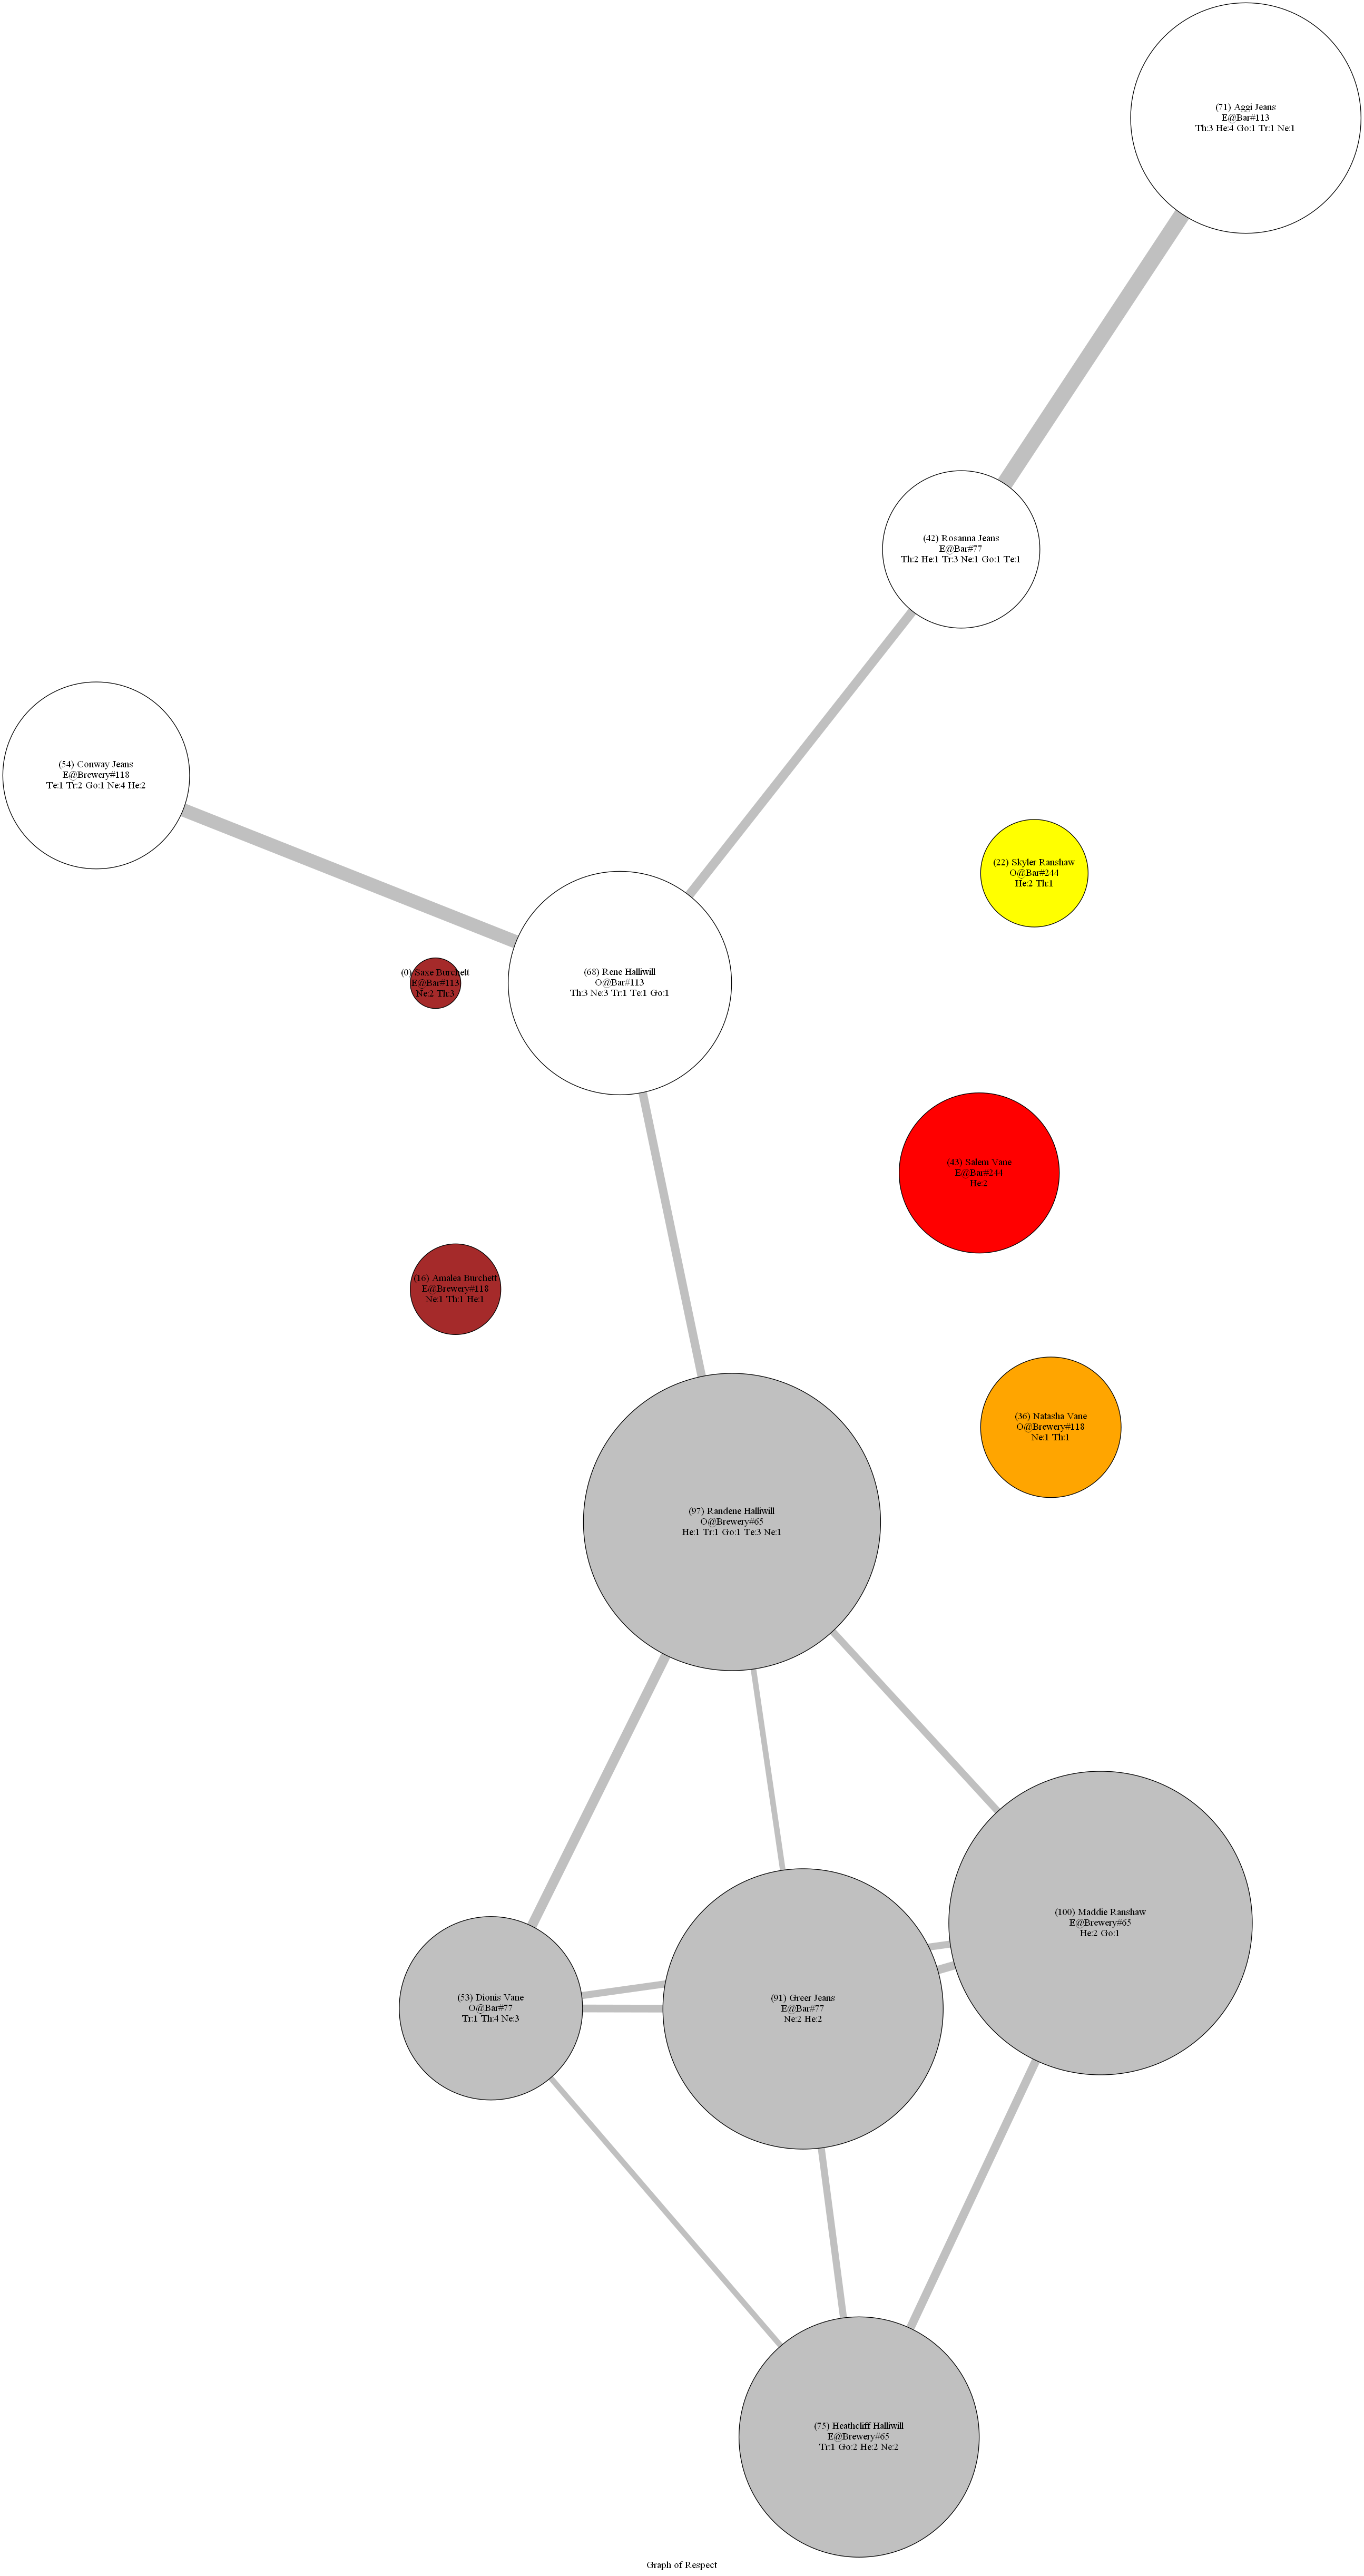

c:\Program Files (x86)\Python310\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'Skyler Ranshaw', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


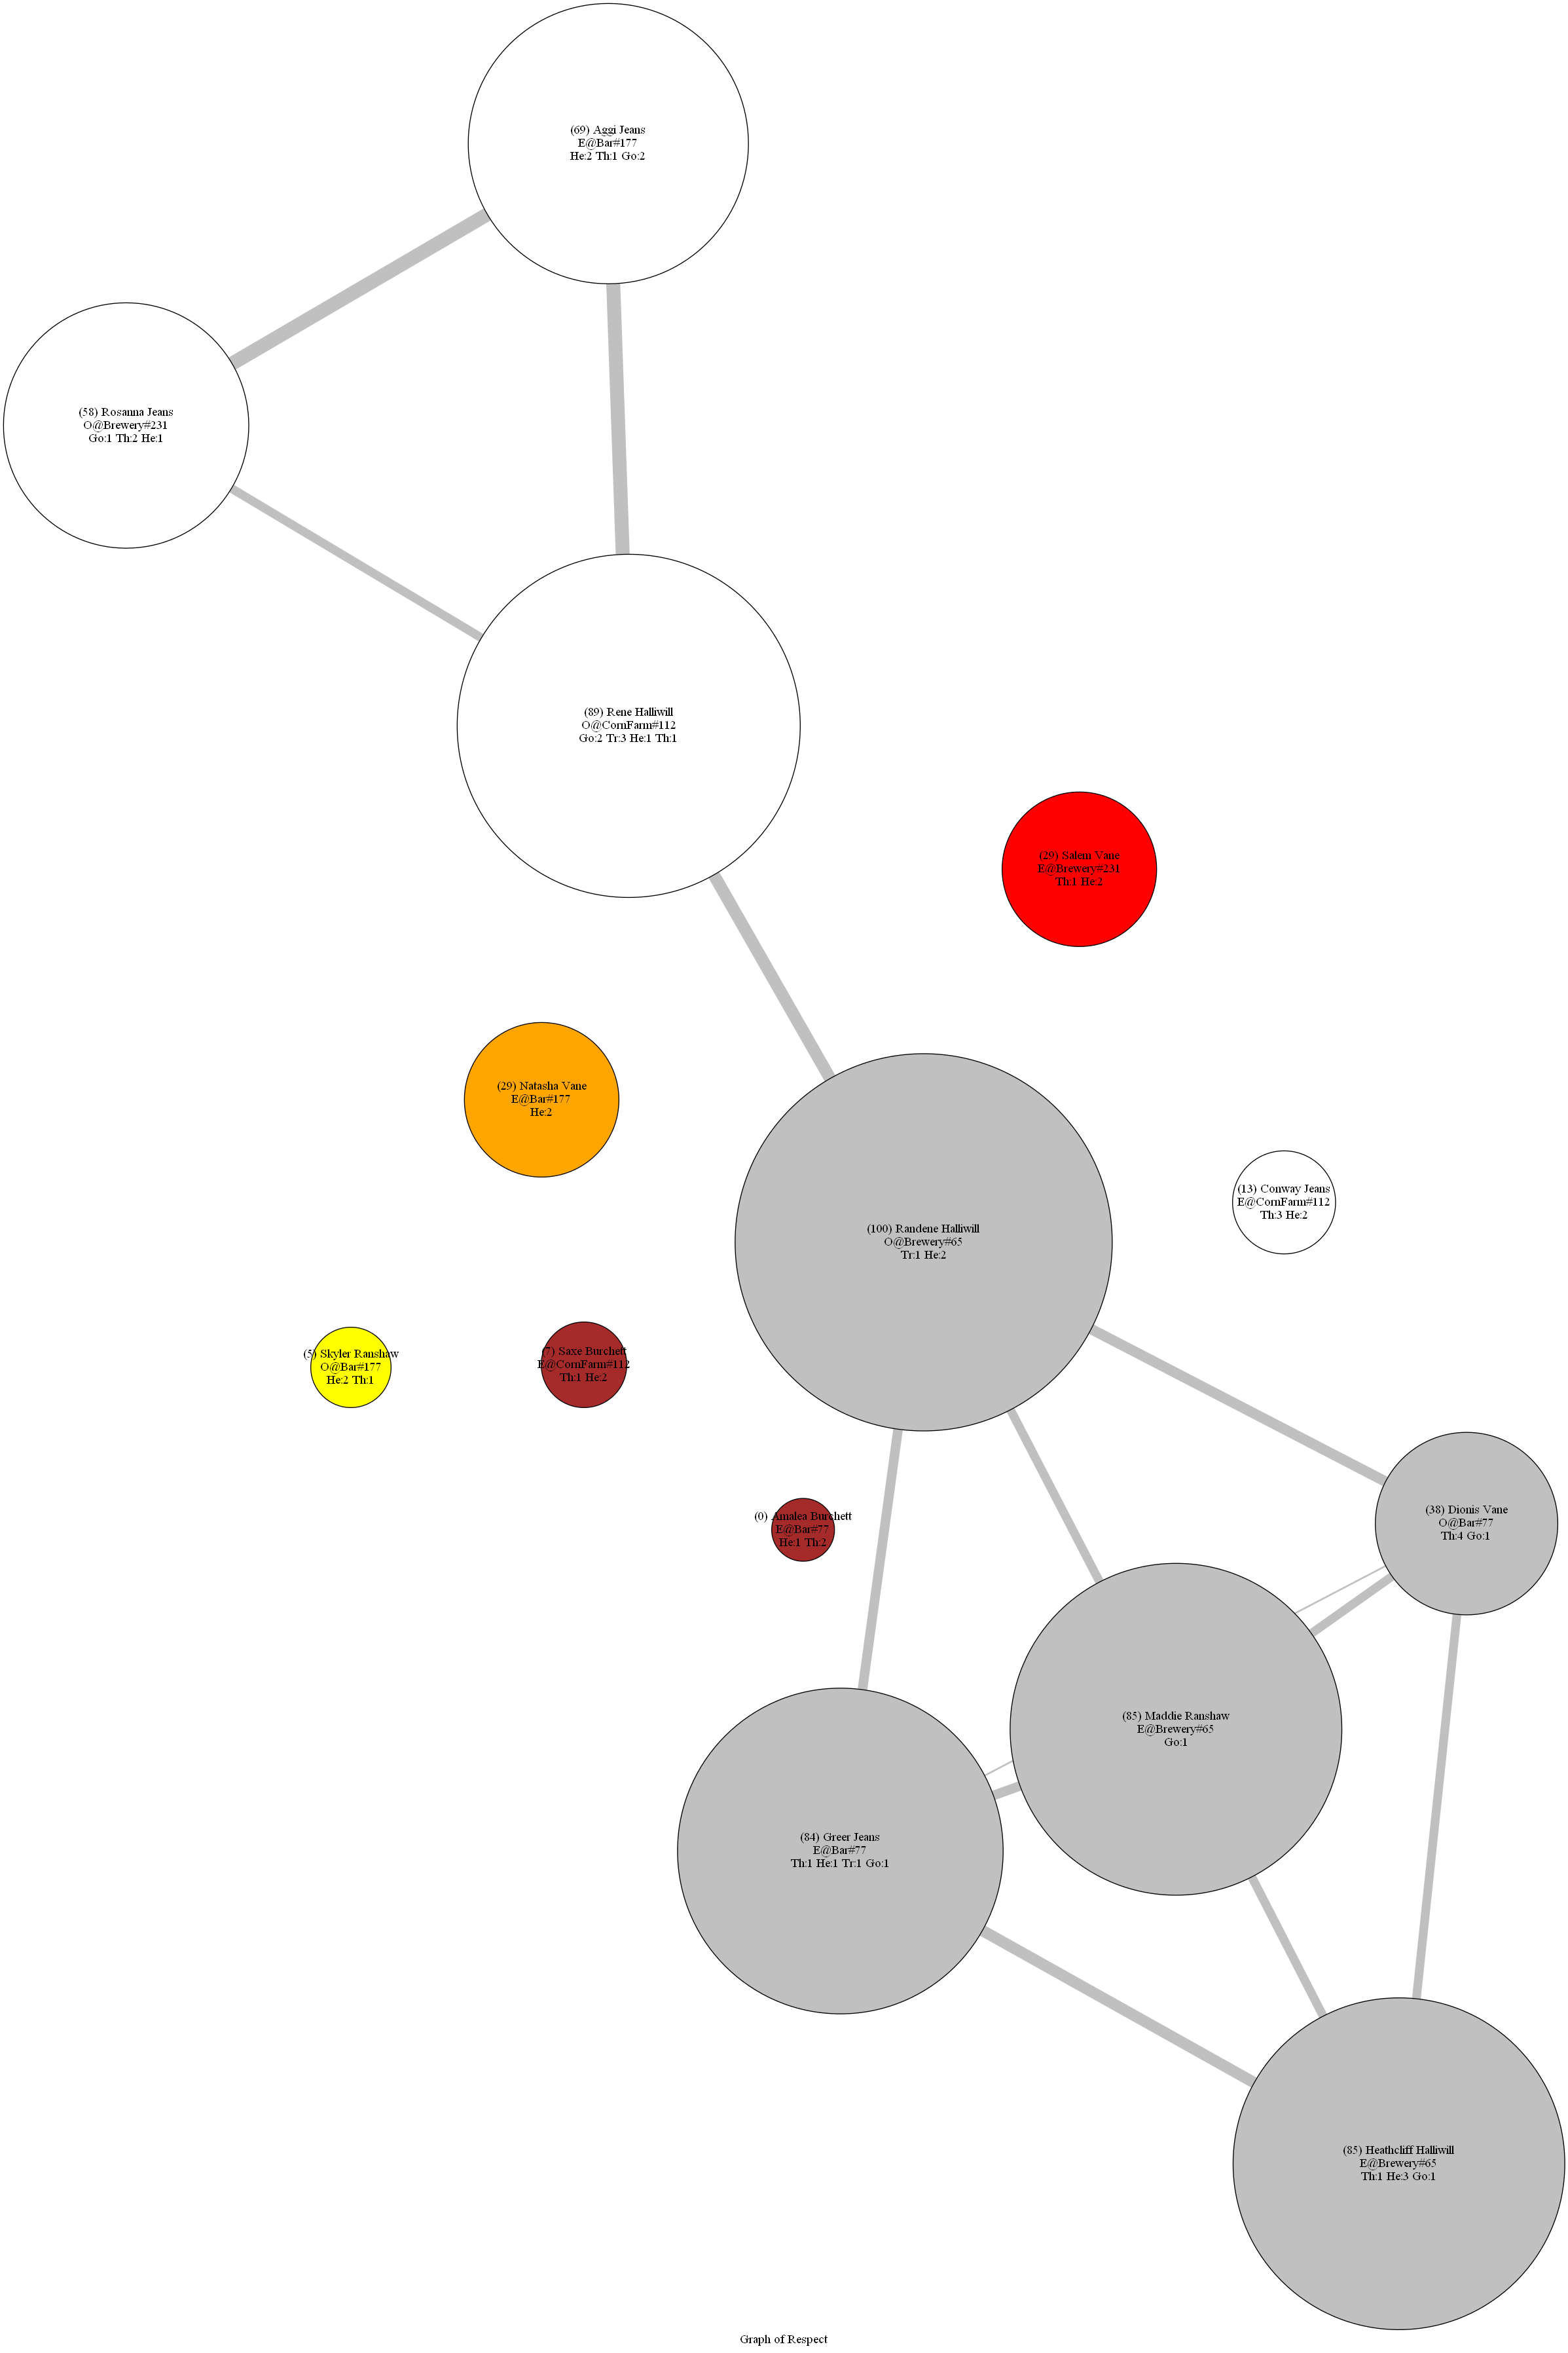

In [17]:
from IPython.display import Image

LAYOUTS_TO_TRY = ["neato", "fdp", "sfdp", "osage"]
LAYOUT_CHOICE = 1

def display_graph(graph : pgv.AGraph, idx):
  graph.graph_attr['overlap'] = 'scale'
  graph_filename = f"{FILE_LOCATION}/{graph.graph_attr['label']} #{idx}.png"
  graph.layout(prog=LAYOUTS_TO_TRY[LAYOUT_CHOICE])
  graph.draw(graph_filename, prog=LAYOUTS_TO_TRY[0])
  display(Image(filename=graph_filename))

for idx, sim in enumerate(sims):
  g = make_relationship_graph(sim, Respect)
  display_graph(g, idx)

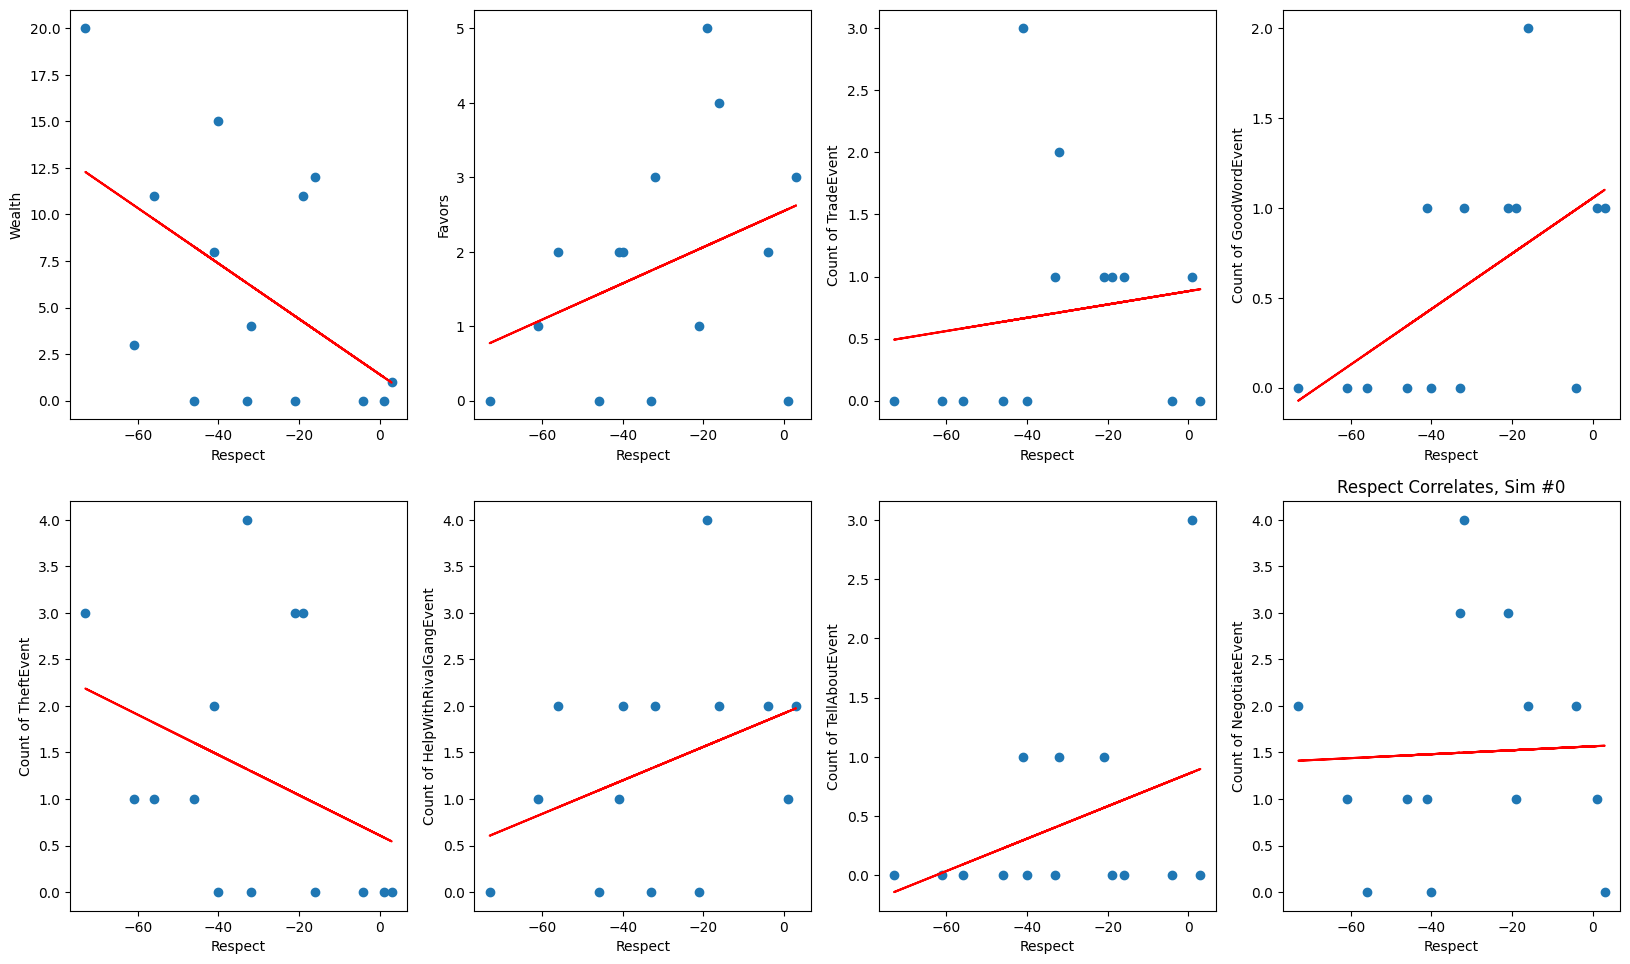

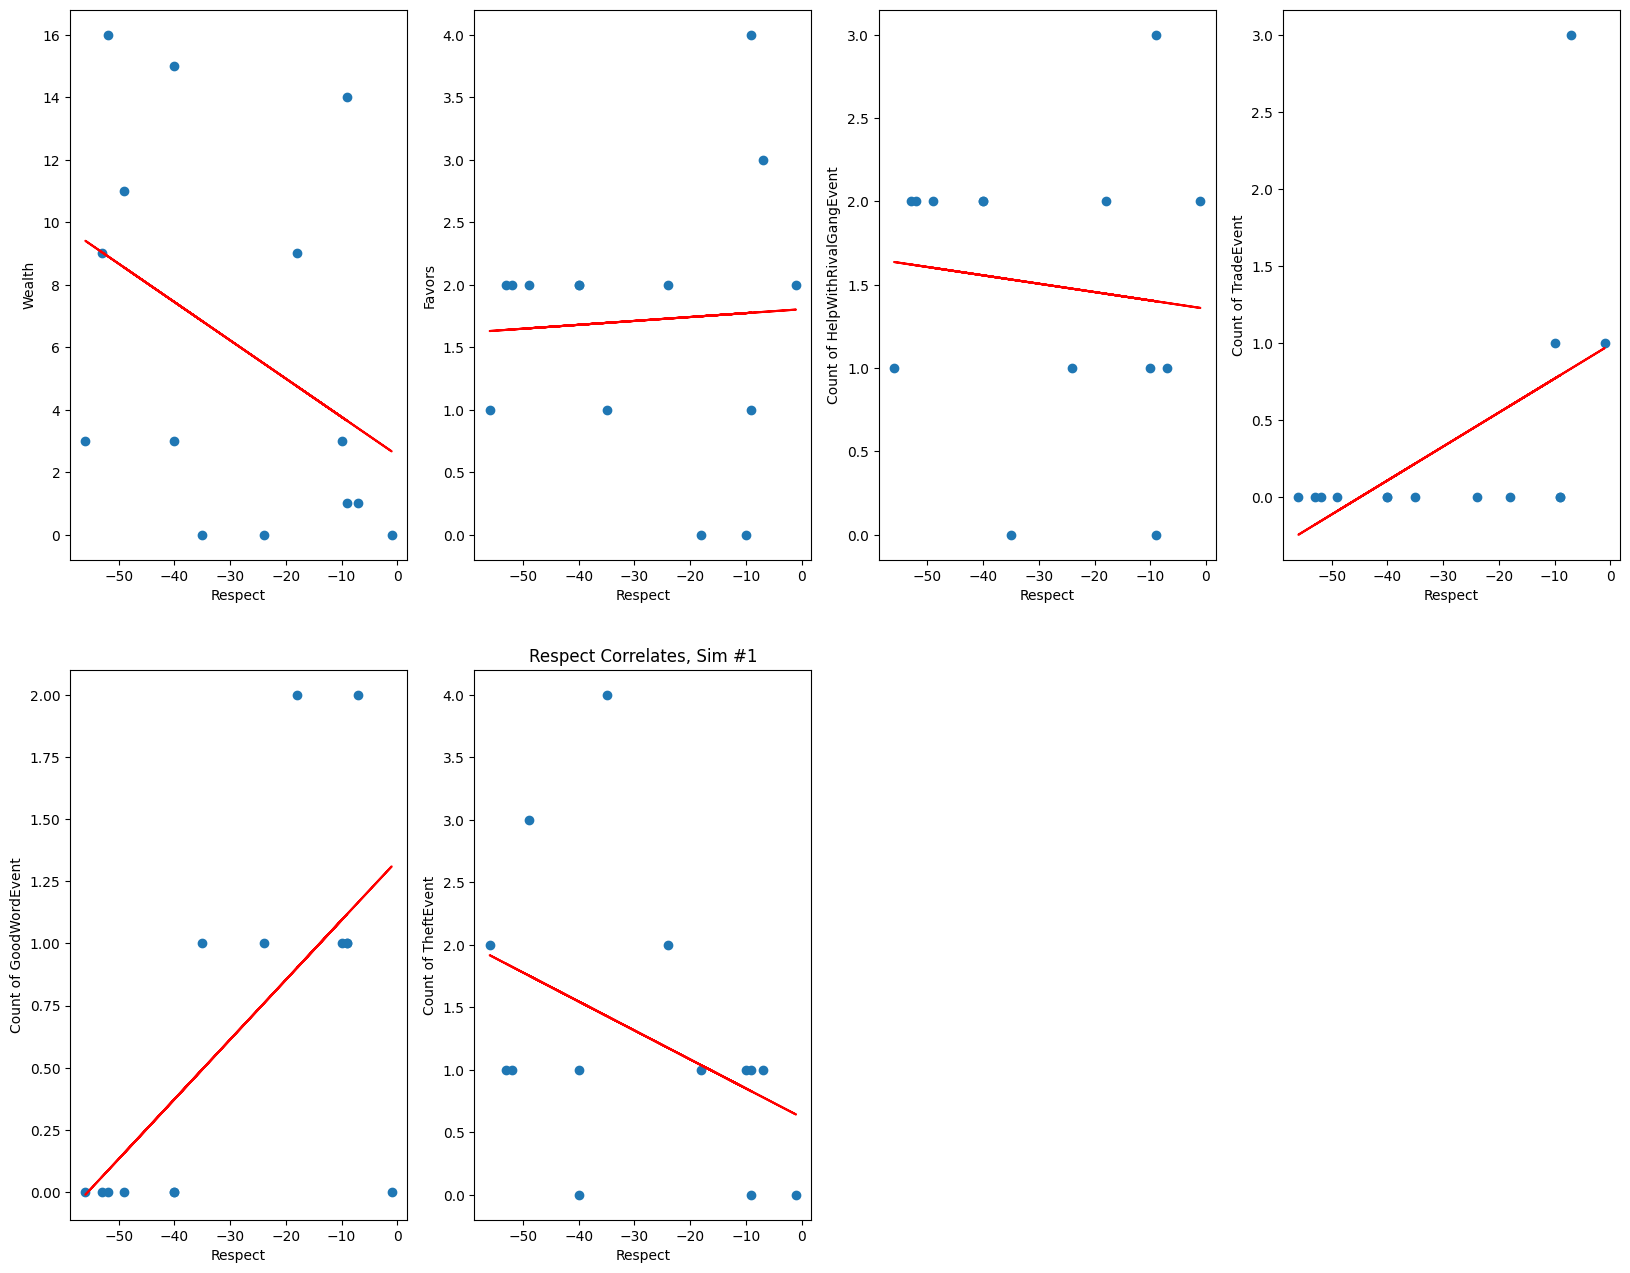

In [12]:
#x and y charts: respect and # items owned?
def chart_respect_vs_wealth(sim : Neighborly):
  wealth_array = []
  respect_array = []
  favors_array = []
  event_counts_array = []
  event_counts_keys = []
  characters = sim.world.get_components((Active, GameCharacter, RelationshipManager, Inventory))
  for character_index in range(len(characters)):
    (id, (active, gamechar, relationship_manager, inventory)) = characters[character_index]
    character_object = sim.world.get_gameobject(id)

    #calculate wealth
    wealth_values = [i for i in inventory.items.values()]
    wealth = sum(wealth_values)
    wealth_array.append(wealth)

    #calculate frequency of actions
    history = character_object.get_component(EventHistory)
    event_type_counts = {}
    for event in history:
        if type(event) in [NegotiateEvent, TradeEvent, GoodWordEvent, TellAboutEvent, TheftEvent, HelpWithRivalGangEvent]:
          if type(event).__name__ not in event_type_counts:
              event_type_counts[type(event).__name__] = 1
          else:
              event_type_counts[type(event).__name__] += 1
          event_counts_keys.append(type(event).__name__)
    event_counts_array.append(event_type_counts)

    #calculate respect
    respect_values = [sim.world.get_gameobject(i).get_component(Respect).get_value() for i in relationship_manager.incoming.values()]
    respect = sum(respect_values)
    respect_array.append(respect)

    favors_values = [sim.world.get_gameobject(i).get_component(Favors).favors for i in relationship_manager.incoming.values()]
    favors = sum(favors_values)
    favors_array.append(favors)

  return (respect_array, wealth_array, favors_array, event_counts_array, list(set(event_counts_keys)))

for idx, sim in enumerate(sims):
  plt.figure(figsize=(20,50))
  (xs, ys, fs, cs, cs_keys) = chart_respect_vs_wealth(sim)
  plt.subplot(2 + len(cs_keys), len(sims) * 2, 8*idx  + 1)
  plt.scatter(xs, ys)
  #obtain m (slope) and b(intercept) of linear regression line
  m, b = np.polyfit(xs, ys, 1)
  #add linear regression line to scatterplot 
  plt.plot(xs, m*np.array(xs)+b, 'r')
  plt.xlabel('Respect')
  plt.ylabel('Wealth')
  

  plt.subplot(2 + len(cs_keys), len(sims) * 2, 8*idx + 2)
  plt.scatter(xs, fs)
  #obtain m (slope) and b(intercept) of linear regression line
  m, b = np.polyfit(xs, fs, 1)
  #add linear regression line to scatterplot 
  plt.plot(xs, m*np.array(xs)+b, 'r')
  plt.xlabel('Respect')
  plt.ylabel('Favors')


  for event_key_idx, event_key in enumerate(cs_keys):
    plt.subplot(2 + len(cs_keys), 2 * len(sims), 8*idx + 3 + event_key_idx)
    counts = [counts.get(event_key, 0) for counts in cs]
    plt.scatter(xs, counts)
    m, b = np.polyfit(xs, counts, 1)
    #add linear regression line to scatterplot 
    plt.plot(xs, m*np.array(xs)+b, 'r')
    plt.xlabel('Respect')
    plt.ylabel('Count of ' + event_key)
  plt.title(f"Respect Correlates, Sim #{idx}")
  plt.show()

In [13]:
from neighborly.core.life_event import AllEvents
from speakeasy.events import GainItemEffect, LoseItemEffect, GainRelationshipEffect, LoseRelationshipEffect, GainKnowledgeEffect, TriggerEventEffect

def make_event_effect_graph(sim: Neighborly):
    event_graph = pgv.AGraph(strict=False, directed=True)
    event_graph.graph_attr["label"] = "Graph of Events"
    event_graph.graph_attr["outputorder"] = 'edgesfirst'

    all_events = sim.world.get_resource(AllEvents)
    print(f"Processing {len(all_events._history)} events")
    for event in all_events:
        if type(event) in [NegotiateEvent, TradeEvent, GoodWordEvent, TellAboutEvent, TheftEvent, HelpWithRivalGangEvent]:
            #print(f"Processing {type(event)} with {len(event.get_effects().items())} items")
            for effect_mapping in event.get_effects().items():
                role = effect_mapping[0]
                effect_list = effect_mapping[1]
                #print(f"Processing {len(effect_list)} effects.")
                for effect in effect_list:
                    if type(effect) is GainItemEffect:
                        event_graph.add_edge(type(event).__name__, effect.item if effect.item else "Unspecified_Item", "Gain")
                        e : pgv.Node = event_graph.get_edge(type(event).__name__, effect.item if effect.item else "Unspecified_Item", "Gain")
                        e.attr["weight"] = str(int(e.attr["weight"] or 0) + 1)
                        e.attr["label"] = f"Gains ({e.attr['weight']})"
                    elif type(effect) is LoseItemEffect:
                        event_graph.add_edge(type(event).__name__, effect.item if effect.item else "Unspecified_Item", "Lose")
                        e : pgv.Node = event_graph.get_edge(type(event).__name__, effect.item if effect.item else "Unspecified_Item", "Lose")
                        e.attr["weight"] = str(int(e.attr["weight"] or 0) + 1)
                        e.attr["label"] = f"Loses ({e.attr['weight']})"
                    elif type(effect) is GainRelationshipEffect:
                        event_graph.add_edge(type(event).__name__, effect.facet.__name__, "Gain")
                        e : pgv.Node = event_graph.get_edge(type(event).__name__, effect.facet.__name__, "Gain")
                        e.attr["weight"] = str(int(e.attr["weight"] or 0) + 1)
                        e.attr["label"] = f"Gains ({e.attr['weight']})"
                    elif type(effect) is LoseRelationshipEffect:
                        event_graph.add_edge(type(event).__name__, effect.facet.__name__, "Lose")
                        e : pgv.Node = event_graph.get_edge(type(event).__name__, effect.facet.__name__, "Lose")
                        e.attr["weight"] = str(int(e.attr["weight"] or 0) + 1)
                        e.attr["label"] = f"Loses ({e.attr['weight']})"
                    elif type(effect) is GainKnowledgeEffect:
                        event_graph.add_edge(type(event).__name__, "Knowledge", "Gain")
                        e : pgv.Node = event_graph.get_edge(type(event).__name__, "Knowledge", "Gain")
                        e.attr["weight"] = str(int(e.attr["weight"]or 0) + 1)
                        e.attr["label"] = f"Gains ({e.attr['weight']})"
                    elif type(effect) is TriggerEventEffect:
                        event_graph.add_edge(type(event).__name__, type(event.triggered_event_class), "Trigger")
                        e : pgv.Node = event_graph.get_edge(type(event).__name__, type(event.triggered_event_class), "Trigger")
                        e.attr["weight"] = str(int(e.attr["weight"] or 0) + 1)
                        e.attr["label"] = f"Triggers ({e.attr['weight']})"
    return event_graph
                        

for idx, sim in enumerate(sims):
  g = make_event_effect_graph(sim)
  print(f"Graph has {len(g.nodes())} nodes and {len(g.edges())} edges.")
  display_graph(g, idx)

Processing 167 events


ComponentNotFoundError: Could not find Component with type Inventory.